# Temos a base de dados Amostra, farei a mineiração dos dados dos campos ('ds', 'y') para executar o Modelo de Previsão de Séries Temporais, o Prophet:
1) Campo Data da Aplicação da Vacina ('ds')
2) Campo Data Descricao Dose 1. Dose e 2. Dose ('y')

In [ ]:
# DATA de Atualização; 04/06/2021

In [1]:
# Importando as principais Bibliotecas:

import csv
import time
import requests 
import pandas  as pd
import numpy   as np
import seaborn as sns
from random   import random
from datetime import datetime
from datetime import date


# Importar bibliotecas para construir gráficos:

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Bibliotecas de Algoritmos de Regressão:

from sklearn.tree            import DecisionTreeClassifier
from catboost                import CatBoostClassifier
from sklearn.metrics         import accuracy_score
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing   import StandardScaler
from sklearn.ensemble        import RandomForestRegressor, ExtraTreesRegressor


# Biblioteca do Prophet para Algoritmo de Previsão:

from prophet             import Prophet
from prophet.plot        import plot_plotly
from prophet.plot        import plot_cross_validation_metric
from prophet.plot        import plot_components_plotly
from prophet.plot        import add_changepoints_to_plot
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation


# Leitura Banco Dados da Amostra no dia 26/05/2021:

df = pd.read_csv("BD_Amostra-Alguns-26-05-2021.csv", sep=";")
usecols   = ['vacina_fabricante_nome',
             'paciente_idade',
             'paciente_id',
             'vacina_dataAplicacao',
             'paciente_endereco_uf',
             'vacina_descricao_dose']

In [2]:
# Definindo Variaveis Globais:

FATOR_AMOSTRA = 0.001 # É o valor da porcentagem obtida pelo Banco de Dados Amostra: 1/1000

In [3]:
# Função para calcular MAPE (Mean absolute percentage error). 
# Essa métrica nos mostra o quanto do ajuste está errado percentualmente.

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 1.º passo: 

1) Preparando o campo para o datetime: formato = %Y-%m-%dT%H:%M:%S"\
2) Denifir que o campo 'vacina_dataAplicacao' terá somente a DATA no formato: AAAA/MM/DD\
3) Remover o TimeZone do campo DATA


In [4]:
# Converter a coluna "vacina_dataAplicacao," datetime somente em date e tratando TimeZOne:

df['vacina_dataAplicacao'] = pd.to_datetime(df['vacina_dataAplicacao']).dt.date

df.dtypes

vacina_fabricante_nome    object
paciente_idade             int64
paciente_id               object
vacina_dataAplicacao      object
paciente_endereco_uf      object
vacina_descricao_dose     object
dtype: object

In [5]:
# Deixando a coluna "vacina_dataAplicacao" que será utilizada no Algoritmo de Previsão de Séries Temporais:

df['vacina_dataAplicacao']

0        2021-03-19
1        2021-03-03
2        2021-03-09
3        2021-04-01
4        2021-03-25
            ...    
61473    2021-05-25
61474    2021-05-07
61475    2021-05-25
61476    2021-05-25
61477    2021-05-25
Name: vacina_dataAplicacao, Length: 61478, dtype: object

In [ ]:
# Ordenando a coluna data: "vacina_dataAplicacao".

# Uma das premissas para se trabalhar com série temporal é que 
# devemos manter a ordem correta dos acontecimentos dos eventos.
# Portanto, vamos ordenar a coluna "vacina_dataAplicacao".


df = df.sort_values('vacina_dataAplicacao')
df['vacina_dataAplicacao'].reset_index()

# 2.º Passo: 
Tratando do campo "vacina_descricao_dose": identificar quais doses foram tomadas da vacina:

   - Primeira Dose 
   - Segunda Dose após um intervalo definido
   - Dose única

In [6]:

df["vacina_descricao_dose"].unique()

array(['\xa0\xa0\xa0\xa01ª\xa0Dose', '\xa0\xa0\xa0\xa02ª\xa0Dose',
       '1ª Dose', '2ª Dose', 'Única'], dtype=object)

# 2.1 Tratando o campo "vacina_descricao_dose":

1) Transformando todos as linhas como Minuúsculas \
2) Quando aparecer Null (NaN) substituir por "-" \
3) Tratando todos os caracteres ASCII 

In [7]:

df["vacina_descricao_dose"] = (df["vacina_descricao_dose"]
                                 .str.lower()
                                 .str.normalize("NFKD")
                                 .str.lstrip()
                                 .str.replace(" ","_")
                                 .str.encode("ascii", errors="ignore")
                                 .str.decode("utf-8"))

## 2.2 Calculando as doses aplicadas por dia da coluna: 'vacina_descricao_dose':

Teremos 3 situações para contabilizar o número de vacinas tomadas:
  1) A Primeira Dose ==> 1a_dose\
  2) A Segunda Dose  ==> Totalmente vacinados com a  2a_dose\
  3) Ser Dose Unica!!

In [ ]:
# A dose unica aparece como valor = 1

# OBS: A vacina Jassen da Johnson&Johnson é somente 1 Dose
# df.loc[df["vacina_descricao_dose"] == 'unica', "vacina_descricao_dose" ] =  '1a_dose'

In [8]:
# Verificando o valor acumulado das doses tomadas:

df["vacina_descricao_dose"].value_counts()

1a_dose    42101
2a_dose    19376
unica          1
Name: vacina_descricao_dose, dtype: int64

# 2.3  Função: Get_Dummies no campo 'vacina_descricao_dose':

1) se não tomou vacina da 1ª Dose' = 0, se tomou a 1ª Dose' = 1 \
2) se não tomou vacina da 2ª Dose' = 0, se tomou a 2ª Dose' = 1

In [9]:

dummies = df["vacina_descricao_dose"].str.get_dummies("\n")
dummies

,1a_dose,2a_dose,unica
0,1,0,0
1,0,1,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
61473,0,1,0
61474,1,0,0
61475,1,0,0
61476,0,1,0


# 2.4  Concatenar a coluna Dummies ao DataFrame:

In [10]:
# Preparando nosso Dataframe:

df = pd.concat([df, dummies], axis = 1)

# Após Concat com o Dummies, o Dataframe df acrescenta mais 3 colunas no df:

df.shape

(61478, 9)

# 3.º Passo: 
Fazendo o cálculo para valores com o FATOR_AMOSTRA

In [11]:
Vacinados_uma_dose = df['1a_dose'].sum()

print('Total REAL de Vacinados com 1. dose = ', Vacinados_uma_dose/FATOR_AMOSTRA)

Total REAL de Vacinados com 1. dose =  42101000.0


In [12]:
Vacinados_duas_doses = df['2a_dose'].sum()

print('Total REAL de Vacinados com 2. dose = ', Vacinados_duas_doses/FATOR_AMOSTRA)

Total REAL de Vacinados com 2. dose =  19376000.0


In [13]:
# Limpando os campos das Doses, retirando os nulos NaN

df['1a_dose'].fillna(0, inplace = True)

df['2a_dose'].fillna(0, inplace = True)

<AxesSubplot:xlabel='count', ylabel='vacina_descricao_dose'>

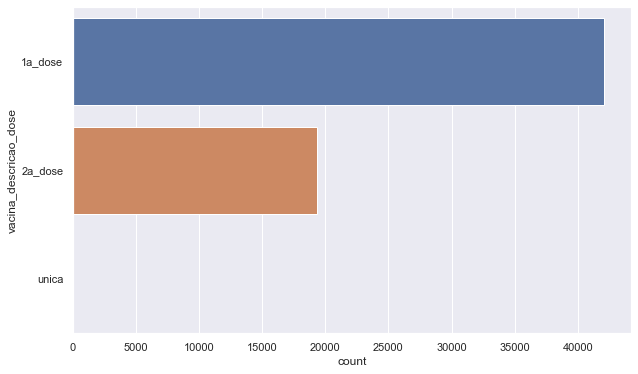

In [14]:
# Plotting das Doses tomadas:

plt.figure(figsize = (10,6))
sns.countplot(data = df, y = "vacina_descricao_dose")

# 3.1 Trabalhando com informações da '1a_dose' 
para executar o algoritmo de PREVISAO:
Neste ponto, vou definir o DataFrame df1 para '1a_dose'

In [15]:
# Agrupando as colunas da Data da Aplicacao com os vacinados da '1a_dose'

df1 = df.groupby('vacina_dataAplicacao').agg({'1a_dose':'sum'}).reset_index()

df1['vacina_dataAplicacao'].value_counts()

2021-02-11    1
2021-02-03    1
2021-01-31    1
2021-02-17    1
2021-03-19    1
             ..
2021-03-26    1
2021-05-12    1
2021-02-16    1
2021-04-16    1
2021-03-22    1
Name: vacina_dataAplicacao, Length: 129, dtype: int64

# 4.º Passo:
Definindo os Dataframes de Train e Teste:

In [ ]:
## Testando.....


df_train = df1.loc[df1['vacina_dataAplicacao']<= pd.to_datetime( '2021-04-26')]

# Pegando as datas após data 26/Abril/2021 até 26/Maio/2021:

df_teste = df1.loc[df1['vacina_dataAplicacao']> pd.to_datetime( '2021-04-26')]

# Preparando as colunas dos DataFrames de Train e Test para verificacao Erros:

df_train.columns =  ['ds', 'y']
df_teste.columns =  ['ds', 'y']

In [16]:
# A base de dados Vacina e a Amostra foram gerados dia 26/05/2021:
# Pegando as datas dos meses anteriomente ao dia 26/Abril/2021

end_date = pd.to_datetime('2021-04-26')

df_train = (df1.loc[df1['vacina_dataAplicacao'] <= end_date])
df_teste = (df1.loc[df1['vacina_dataAplicacao'] > end_date])


df_train.columns =  ['ds', 'y']
df_teste.columns =  ['ds', 'y']


# 5.º Passo: 

Preparando para rodar o Algoritmo do Prophet para Previsao Séries Temporais: \
dois campos importantes 'ds' e 'y', onde:\
ds       => é a coluna DATA e já está no formato de AAAA-MM-DD\
coluna y => deve ser numérica e representa a medida que desejamos prever:\

A coluna 'y' contém a soma diária das doses e separando em duas etapas as previsões: \
 y = 1.dose total da para dataframe ==> df1 \
 y = 2.dose para dataframe          ==> df2

In [17]:
# A primeira etapa será previsão da 1.dose:

df1.tail(5)

,vacina_dataAplicacao,1a_dose
124,2021-05-21,342
125,2021-05-22,231
126,2021-05-23,26
127,2021-05-24,294
128,2021-05-25,235


# Importante: 
É necessário renomear os nomes das colunas 'ds' e'y' para rodar o Prophet

In [18]:
# Renomeando as colunas para preparar para rodar o Modelo Prophet:


df1.columns = ['ds', 'y']

<AxesSubplot:title={'center':'Tempo Data Series'}, xlabel='ds'>

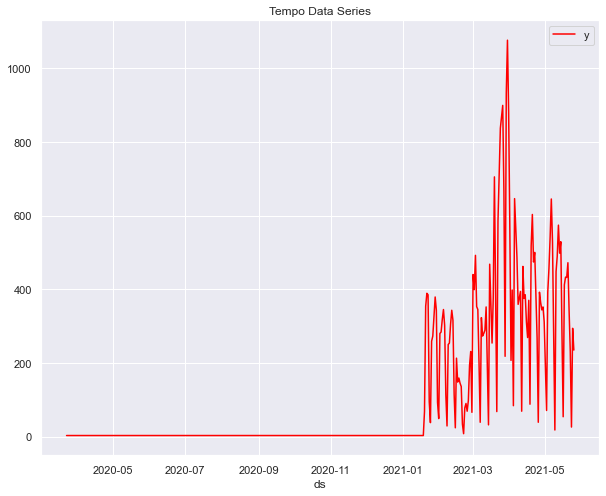

In [19]:
# Plotting the TIme Series Data:

df1.plot(x ='ds', y ='y', figsize = (10,8), title = 'Tempo Data Series' , color = 'red')

No handles with labels found to put in legend.


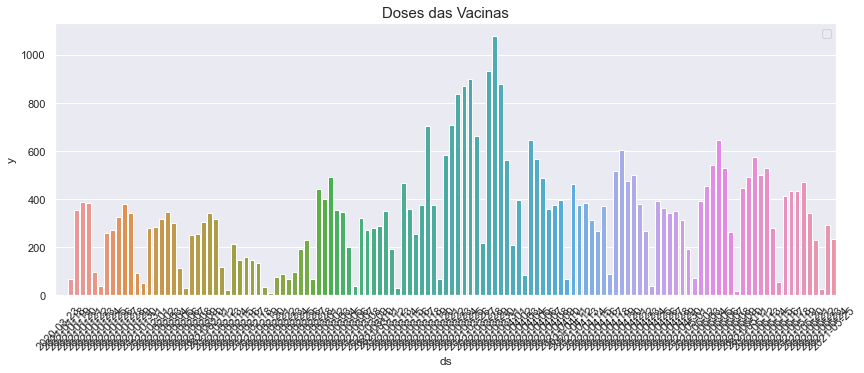

In [20]:
# Plotting Doses Vacinas:

fig, ax = plt.subplots(figsize=(14,5))
palette = sns.color_palette("mako_r", 4)
ax      = sns.barplot(x= "ds", y="y", data = df1)


ax.set_title("Doses das Vacinas", fontsize=15)

# Somente tirando a legenda para fora do gráfico:

plt.legend(loc='upper right')
plt.xticks(rotation=45)
plt.show()


# 6.º Passo: 
Definifindo a sazonalidade dos períodos: diario, mensal, anual ou quinzenal:

In [21]:
# Definindo a sazonalidade diaria, semanal e mensal terá mais controle sobre a sazonalidade. 

model = Prophet(daily_seasonality      = False,
               weekly_seasonality      = False,
               yearly_seasonality      = False,
               ).add_seasonality(name= 'mounthly',
                                 period = 30,
                                 fourier_order = 12
                ).add_seasonality(name = 'dayly',
                                 period = 1,
                                 fourier_order = 15
                                 ).add_seasonality(name = 'weekly',
                                 period = 7,
                                 fourier_order = 20,
                ).add_seasonality(name= 'yearly',
                                 period = 365.25,
                                 fourier_order = 20
                ).add_seasonality(name= 'quartely',
                                 period = 365.25/4,
                                 fourier_order = 5,
                                 prior_scale = 15)
                

# 7.º Passo: 
## Executando o Modelo de Prophet()

Definindo parâmetros do Prophet(), assegurando que teremos a previsão positiva:


In [22]:
# Fazendo Saturações Previsões de Crescimento:

model = Prophet()

# Faremos o treinamento:
model.fit(df1)


# O Prophet disponibiliza um dataframe adequado que se estenda para o futuro 
# por um número especificado de dias (que escolhemos para prever) 
# usando o método auxiliar `make_future_dataframe.

future   = model.make_future_dataframe(periods = 365) # previsão de 1 ano 


# O método PREDICT, atribuirá cada linha em future um valor previsto que ele nomeia "yhat". 
# Se você passar datas históricas, isso fornecerá um ajuste na amostra. 
# O objeto FORECAST é um novo dataframe que inclui uma coluna yhatcom a previsão, 
# bem como colunas para componentes e intervalos de incerteza.

forecast = model.predict(future)

# A coluna yhat representa as previsões, 
# o yhat_lower e yhat_upper são as componentes do intervalo de incertezas
# Quanto mais distante o tempo à frente, mais incerto fica a previsão.


forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
489,2022-05-21,840.911142,631.648763,1053.597866
490,2022-05-22,643.027603,422.324886,855.044170
491,2022-05-23,993.534785,760.832367,1205.143824
492,2022-05-24,990.130664,774.292790,1221.453013
493,2022-05-25,1020.635811,803.551939,1243.407920


# 8.º Passo: Plotting dados:
## Explicando o gráfico:
1) Usando a add_changepoints_to_plotfunção, adicionamos as linhas vermelhas; \
2) As linhas tracejadas verticais são pontos de mudança que o Prophet identificou\
onde a tendência mudou, \
3) A linha vermelha contínua, é a tendência com toda a sazonalidade removida.

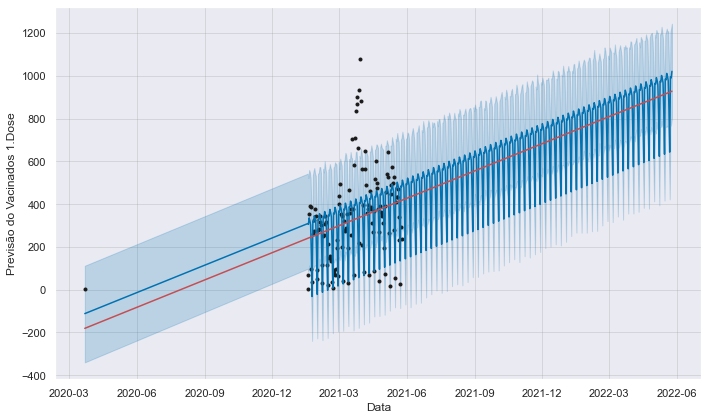

In [23]:
# Plotting, as previsões do modelo treinado:



fig1 = model.plot(forecast, xlabel = 'Data', ylabel = 'Previsão do Vacinados 1.Dose')
a    = add_changepoints_to_plot(fig1.gca(), model, forecast)


<AxesSubplot:title={'center':'Data Atual x Previsão'}, xlabel='ds'>

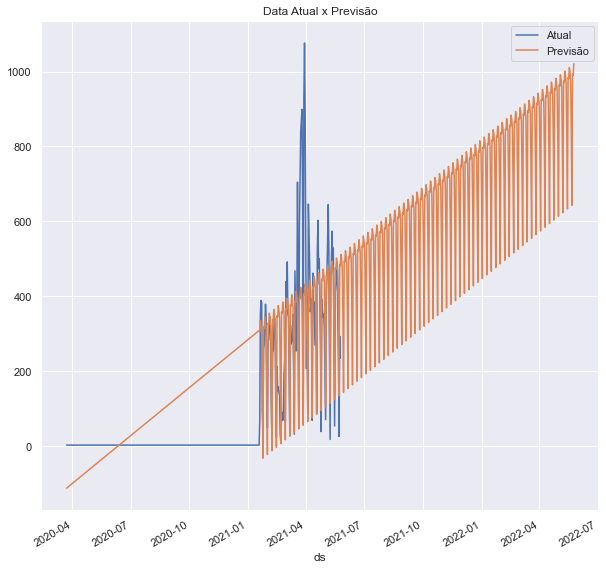

In [24]:
# Plotting o atual e os valores obtidos do Forecast:

ax = (df1.plot(x = 'ds', y = 'y',  figsize =(12,8), label='Atual', title = "Data Atual x Previsão"))
forecast.plot( x = 'ds', y ='yhat',figsize =(10,10), label ='Previsão' ,title = "Data Atual x Previsão", ax =ax )

# Definindo os Dataframes de Train e Teste

In [ ]:
# Definindo os campos de y_true e y_pred para calcular erro,
# chamando a Função Mean_Absolute_Percentage_ERROR

y_true = df_teste['y']
y_pred = model.predict(df_teste['ds'])

print("Train shape", y_true.shape)
print("Test shape",  y_pred.shape)


mape = mean_absolute_percentage_error(y_true, y_pred)

print("MAPE", round(mape,4))


# 9.º Passo:

# Calculando as métricas: 
## Função Cross-Validation:

Esse procedimento de validação cruzada pode ser feito automaticamente para uma faixa de cortes históricos usando a função cross_validation. 

Especificamos:
1) o horizonte de previsão ( horizon) 
2) opcionalmente, o tamanho do período de treinamento inicial ( initial) 
3) o espaçamento entre as datas de corte ( period), o período de treinamento inicial é definido como três vezes o horizonte e os cortes são feitos a cada meio horizonte.

# Entendendo a saída do resultado Cross_Validation:
A saída de cross_validation é um dataframe com os valores reais 'y' 
e os valores de previsão fora da amostra 'yhat', em cada data de previsão simulada e para cada data de corte.
Em particular, uma previsão é feita para cada ponto observado entre cutoffe cutoff + horizon. Esses dados podem então ser usados para medidas de erro de computação de 'yhat' e 'y'.

Aqui, fazemos validação cruzada para avaliar:
1) desempenho da previsão em um horizonte de 30 dias, 
2) começando com 365 dias de dados de treinamento no primeiro corte
3) fazendo previsões a cada 10 dias.

In [25]:
# Utilizando a Função Cross-Validation

df_cross = cross_validation(model, initial = '365 days', period = '10 days', horizon = '30 days') 

INFO:prophet:Making 4 forecasts with cutoffs between 2021-03-26 00:00:00 and 2021-04-25 00:00:00


In [26]:
df_cross.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-03-27,217.770954,10.273358,412.571164,664,2021-03-26
1,2021-03-28,95.437556,-101.626933,286.162930,218,2021-03-26
2,2021-03-29,374.193278,176.375878,566.217044,932,2021-03-26
3,2021-03-30,347.439926,154.650654,539.767470,1076,2021-03-26
4,2021-03-31,401.342066,196.544678,582.251831,880,2021-03-26


In [27]:
# Vericando as Metricas:

df_perform = performance_metrics(df_cross)
df_perform.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,55413.198890,235.400083,174.804529,0.435551,0.431214,0.446463,0.833333
1,4 days,79388.158407,281.759043,181.076638,0.382542,0.383579,0.406624,0.833333
2,5 days,99616.722685,315.621170,226.866075,0.419973,0.438740,0.440680,0.750000
3,6 days,74629.965341,273.184856,186.657667,0.441455,0.330680,0.410693,0.833333
4,7 days,34342.031905,185.316033,141.064354,0.560631,0.398658,0.421930,0.833333


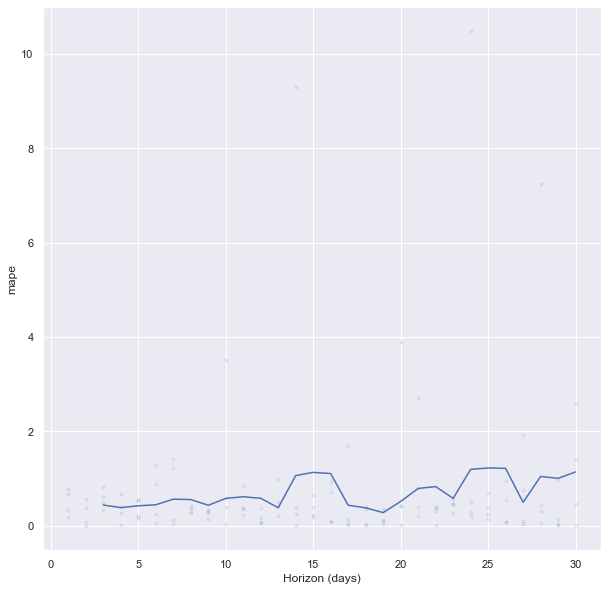

In [28]:
# Plotting a Performance:

fig = plot_cross_validation_metric(df_cross, metric='mape', figsize = (10,10))

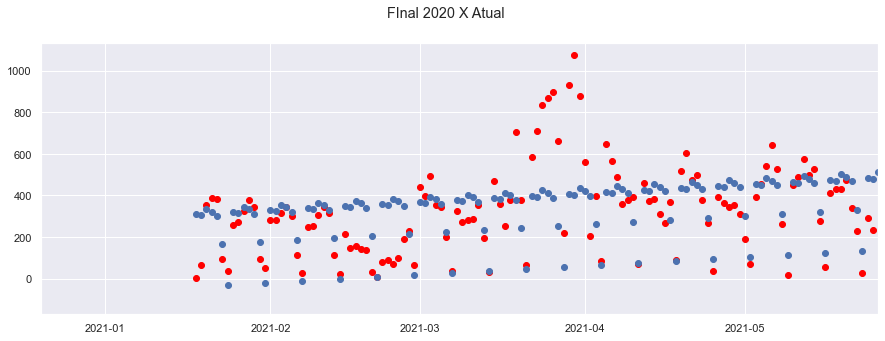

In [29]:
# Plotting Forecast:

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

# Inicio da Vacinação no Brasil 18/12/2020

ax.scatter(df1['ds'], df1['y'], color='red', label="Atual")
ax.scatter(forecast['ds'], forecast['yhat'], label= 'Previsao')

# Plotting o atual e os valores obtidos do Forecast:

ax.set_xbound(lower ='2020-12-20', upper ='2021-05-26')
# ax.set_ylim(0, 1000)
plot = plt.suptitle('FInal 2020 X Atual')

# 10.º Ajustando os parâmetros do Prophet para melhorar a previsão:

## Ajustando Parâmetros para melhorar a previsão:

1) Definindo o parâmetro "grown = logistic", crescimento logístico:\
2) o limite (valor máximo que seus dados alcançarão)  o piso (valor mínimo que seus dados alcançarão)\
de suas previsões;\
3) changepoint_range

Dica: O limite máximo da população vacinada é de 211.755.692 de brasileiros, \
pois muito provavelmente não atingirá esse limite dentro do tempo que está prevendo. \
Vou definir algo mais razoável, como 500.000, e deixar o limite aumentar lentamente com o tempo.

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


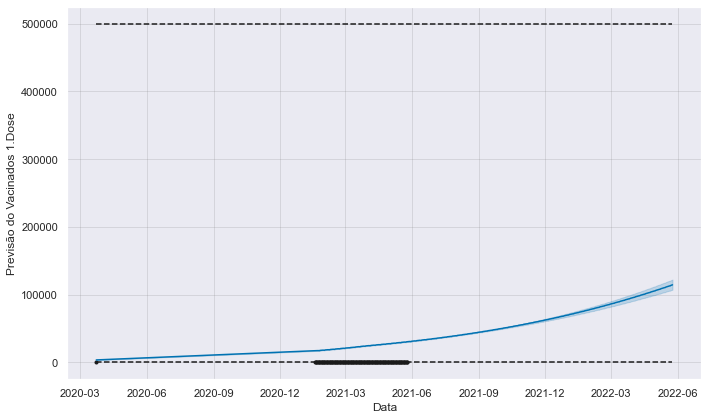

In [30]:
# Prophet usa um modelo linear para sua previsão, e podemos usar um modelo de
# 1) A tendência de crescimento logística, "growth = logistic"

# 2) Dois parâmetros são importantes no modelo:
# o parâmetro FLOOR = 1     ==> mínimo de saturação 
# o parâmetro CAP   = 7000  ==> especifica o valor máximo, CAP = populacao brasileira

# 3) Parâmetro Trend, podemos ajustar a flexibilizar a tendência:

# 4) changepoint_prior_scale: é provavelmente o parâmetro de maior impacto, pois determina
# a flexibilidade da tendência e o quanto a tendência muda nos pontos de mudança de tendência. 
# Conforme descrito nesta documentação, se for muito pequeno, a tendência será insuficiente e a variância que deveria ter sido modelada com mudanças de tendência, em vez disso, acabará sendo tratada com o termo de ruído. Se for muito grande, a tendência se ajustará demais e, no caso mais extremo, você pode acabar com a tendência capturando a sazonalidade anual. O padrão de 0,05 funciona para muitas séries temporais, mas isso pode ser ajustado; uma faixa de [0,001, 0,5] provavelmente seria correta. Parâmetros como este (penalidades de regularização;

# Se as mudanças de tendência estão sendo super ajustadas (flexibilidade demais)
# ou insuficientes (flexibilidade insuficiente), você pode ajustar a força da dispersão antes de usar 
# o argumento de entrada changepoint_prior_scale. 
# Por padrão, este parâmetro é definido como 0,05, aumentar tornará a tendência mais flexível


# OBS: FLOOR e CAP devem ser especificados para CADA colunas do DataFrame, com
# valores Mínimo e Máximo

# Foi definido o parâmetro Future['cap'] = 500.000 corresponde ao número máximo de
# brasileiros vacinados.

df1['cap']  = 7000   # media vacinados por dia
df1['floor'] = 1      # valor do piso

model = Prophet(growth = 'logistic', changepoint_range = 1, changepoint_prior_scale = 0.5)  # define crescimento logistico
 
# Calculando treinamento:
model.fit(df1)

# Fazendo a previsão:

future        = model.make_future_dataframe(periods = 365)


future['cap']   =   500000                # Populacao Brasileira = 211755692  
future['floor'] = 1

forecast = model.predict(future)


# Plotting com novas previsões:

fig3 = model.plot(forecast, xlabel = 'Data', ylabel = 'Previsão do Vacinados 1.Dose')

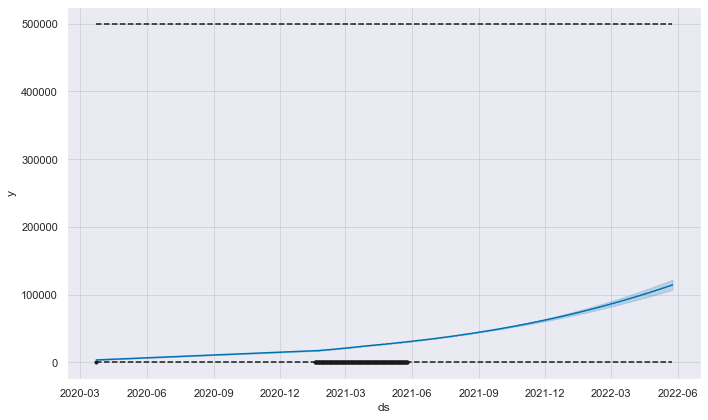

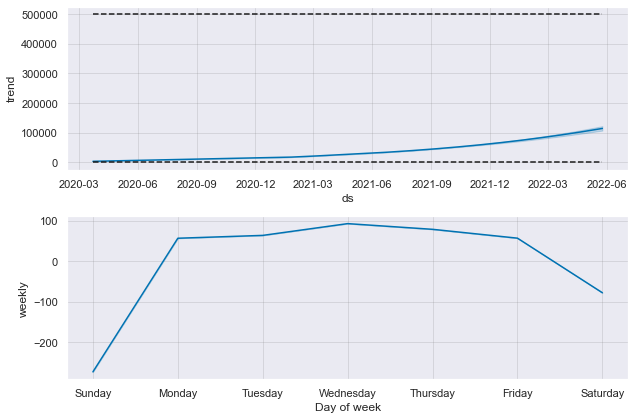

In [31]:
# Fazendo o Plotagem da Previsão:

fig4 = model.plot(forecast, uncertainty = True)

fig5 = model.plot_components(forecast)

In [32]:
# Explicando as métricas obtidas:

# yhat: o valor previsto de nossa métrica (em Estatísticas) 
#       yhat é uma notação tradicionalmente usada para representar os valores previstos de um valor y)

# yhat_lower: o limite inferior de nossas previsões
# yhat_upper: o limite superior de nossas previsões


forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
489,2022-05-21,112835.536490,105768.653435,120353.974565
490,2022-05-22,113004.876329,105939.901498,120569.244761
491,2022-05-23,113701.124722,106664.674547,121371.059755
492,2022-05-24,114074.836743,106889.660684,121803.683571
493,2022-05-25,114471.407719,107276.599024,122241.801087


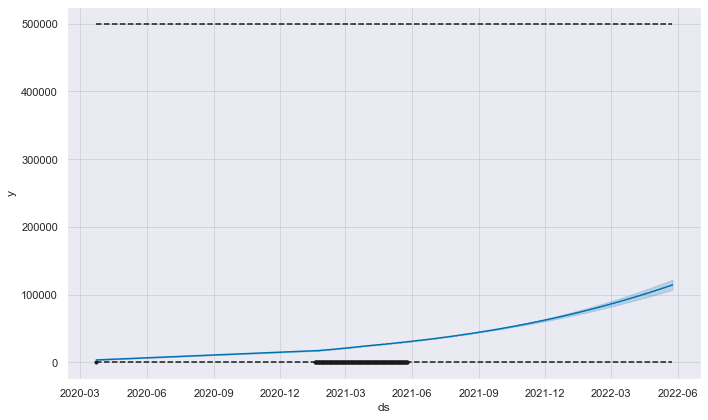

In [33]:
fig = model.plot(forecast)

<AxesSubplot:title={'center':'DADOS ATUAIS X FUTURO'}, xlabel='ds'>

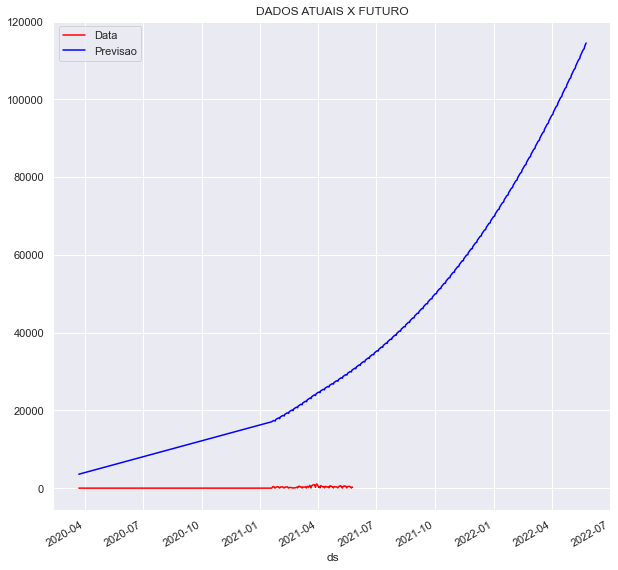

In [34]:
# Plotting comparando valores: Atual x Futuro: 

ax = (df1.plot(x= 'ds', y = 'y',   legend = True, label = 'Data', figsize= (10,30), color = 'red')) 
forecast.plot(x= 'ds',  y ='yhat', legend = True, label = 'Previsao', figsize=(10,10),title='DADOS ATUAIS X FUTURO', color ='blue',ax=ax)

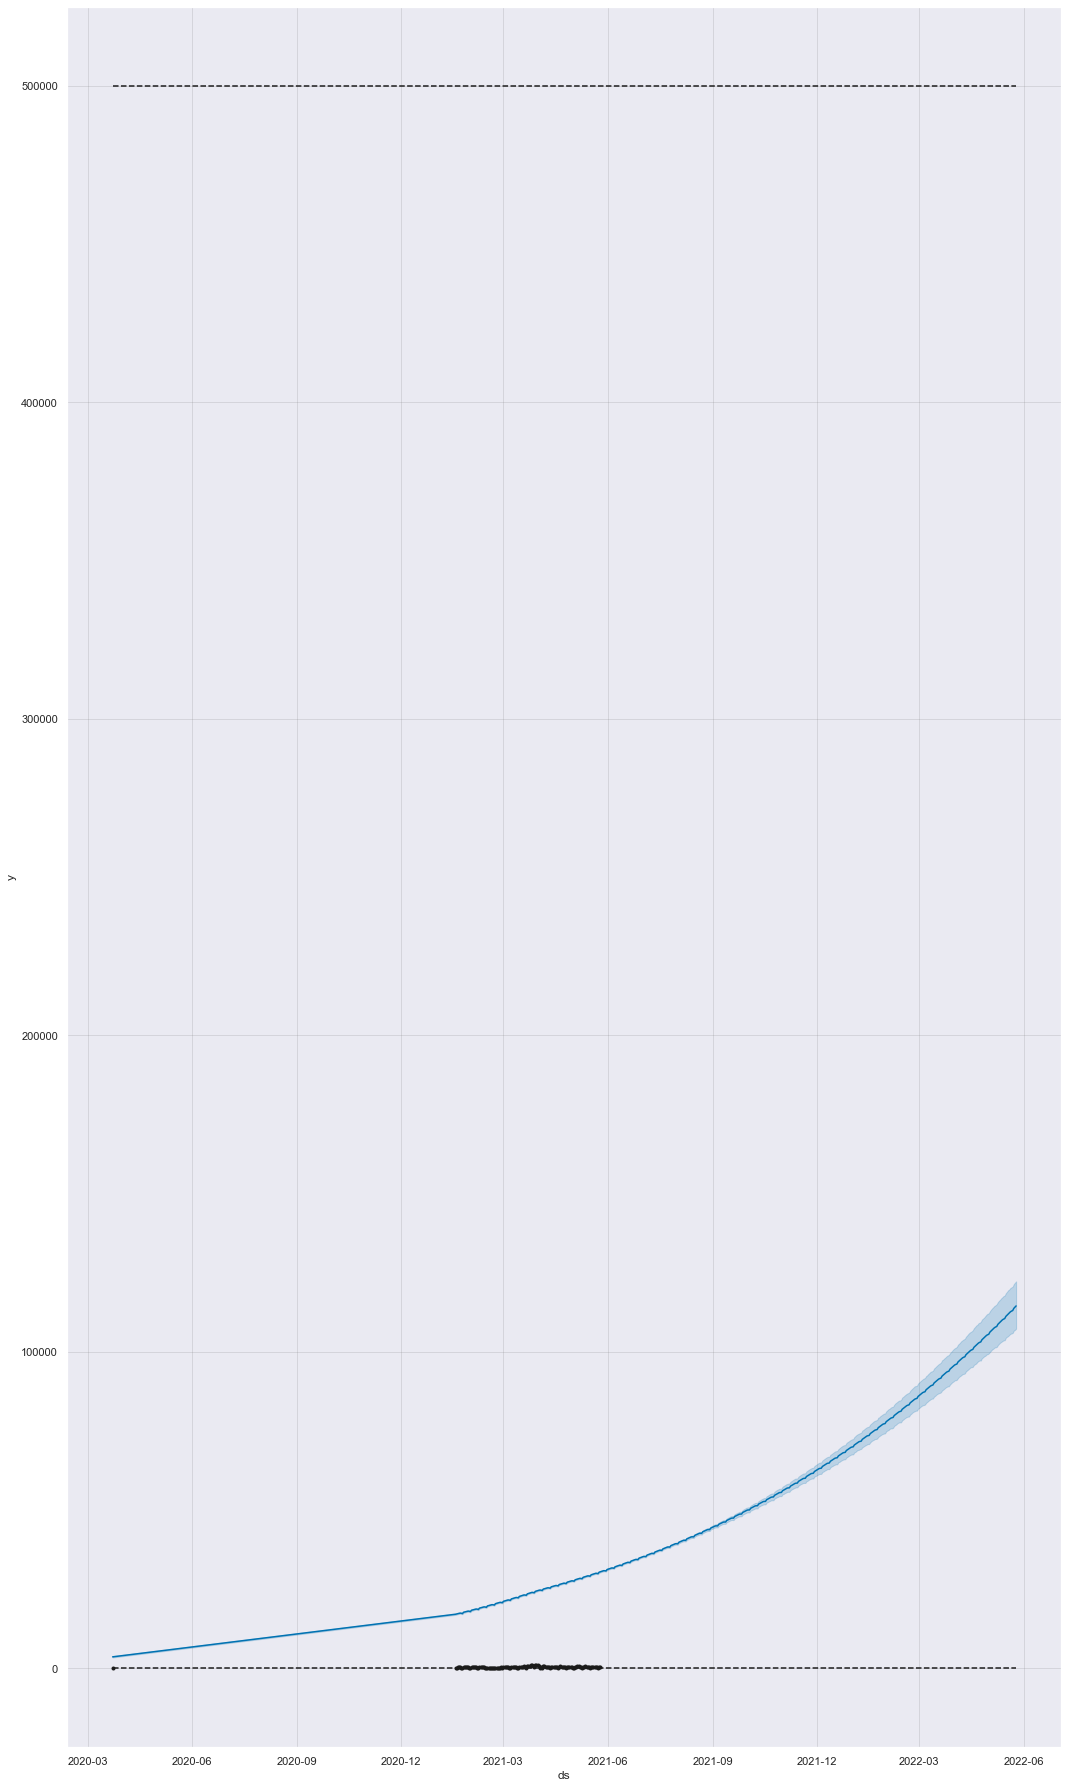

In [35]:
# Plotting o forecast:
f, ax = plt.subplots(1)

f.set_figheight(25)
f.set_figwidth(15)
fig = model.plot(forecast, ax=ax)
plt.show()

# Fazendo nova análise de Cross_Validation para verificar se melhorou os resultados:

In [36]:
# Utilizando a Função Cross-Validation

df_cross = cross_validation(model, initial = '365 days', period = '10 days', horizon = '30 days') 

INFO:prophet:Making 4 forecasts with cutoffs between 2021-03-26 00:00:00 and 2021-04-25 00:00:00


In [37]:
# Vericando as Metricas:

df_perform = performance_metrics(df_cross)
df_perform.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,62134.359121,249.267646,230.702983,0.716599,0.494717,0.504373,0.500000
1,4 days,80984.236704,284.577295,255.270050,0.711488,0.563513,0.512971,0.416667
2,5 days,85046.416247,291.627187,263.303667,0.707517,0.582629,0.510831,0.333333
3,6 days,73149.645089,270.461911,237.106563,0.932861,0.497166,0.504013,0.416667
4,7 days,67102.683367,259.041856,229.402894,1.243397,0.593036,0.588594,0.500000


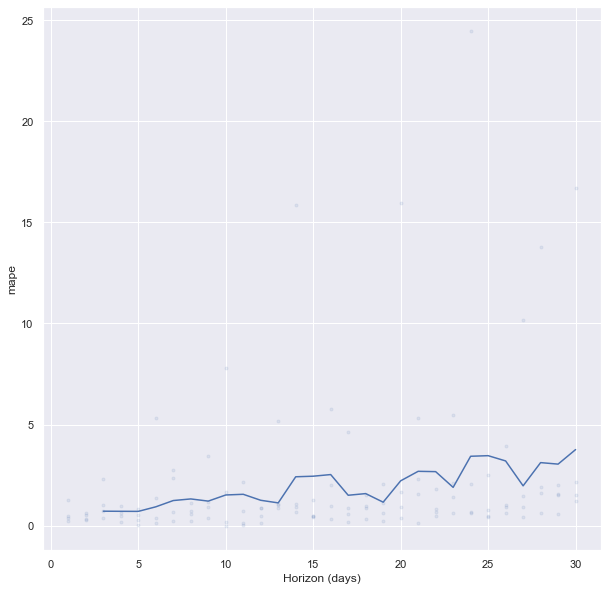

In [38]:
# Plotting a Performance: MAPE

fig = plot_cross_validation_metric(df_cross, metric='mape', figsize = (10,10))

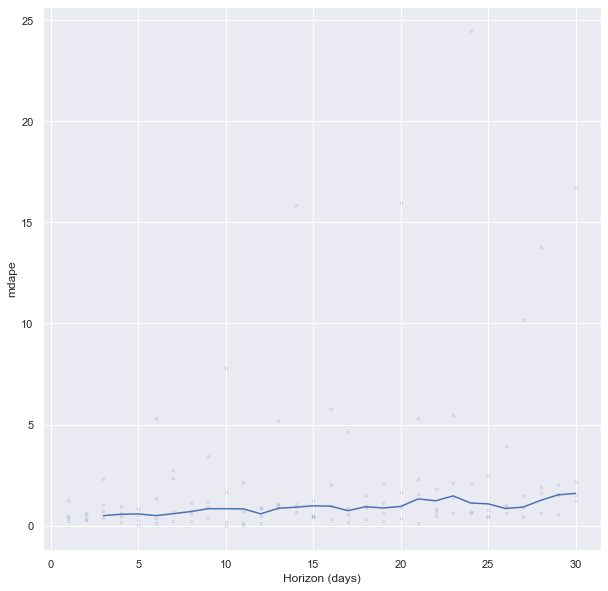

In [39]:
# Plotting Median Absolute Percentage Error: MDAPE
figura = plot_cross_validation_metric(df_cross,metric = 'mdape', figsize = (10,10))

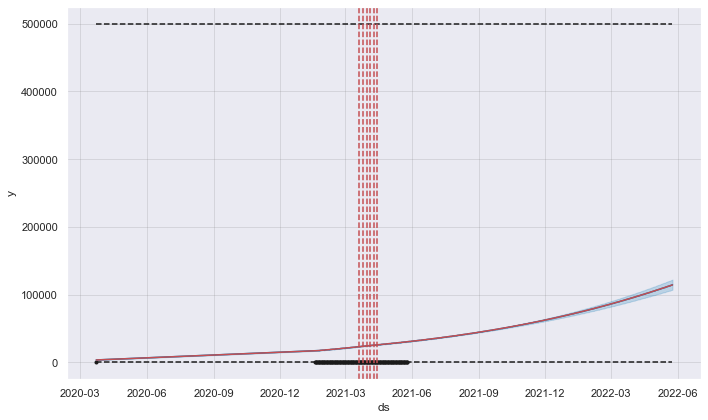

In [40]:
# Plotting dados Atual x Futuro

fig = model.plot(forecast)
a   = add_changepoints_to_plot(fig.gca(), model, forecast)

# 11.º Passo:
Adicionando os feriados deste ano de 2021 do calendário do Brasil:

In [41]:
# Adicionando os Feriados do Brasil para melhorar a acurária da Previsão da Serie Temporal:

import holidays
    
feriado = holidays.Brazil()

# Feriados no Brasil:
for feriado in feriado['2021-01-01': '2021-12-31'] :
    print(feriado)

2021-01-01
2021-02-16
2021-02-17
2021-04-02
2021-04-04
2021-04-21
2021-05-01
2021-06-03
2021-09-07
2021-10-12
2021-11-02
2021-11-15
2021-12-25


In [42]:
playoffs = pd.DataFrame ({
  'holiday': 'playoff', 
  'ds': pd.to_datetime (['2021-01-01', '2021-02-16', '2021-02-17', '2021-04-02', '2021-04-04', 
                          '2021-04-21', '2021-05-01', '2021-06-03', '2021-09-07', '2021-10-12',
                          '2021-11-02', '2021-11-15', '2021-12-25']), 
  ' lower_window ': 0, 
  ' upper_window ': 1, 
})

others = pd.DataFrame({  
  'holiday': 'others',
  'ds': pd.to_datetime(['2021-07-09', '2021-11-20']),
  'lower_window': 0,
  'upper_window': 1,
})

holidays = pd.concat((playoffs, others))

# 12.º Informando os feriados do calendeario e rodando novamente o Prophet
para verificar se houve melhoria da previsao

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<AxesSubplot:title={'center':'DADOS ATUAIS X FUTURO'}, xlabel='ds'>

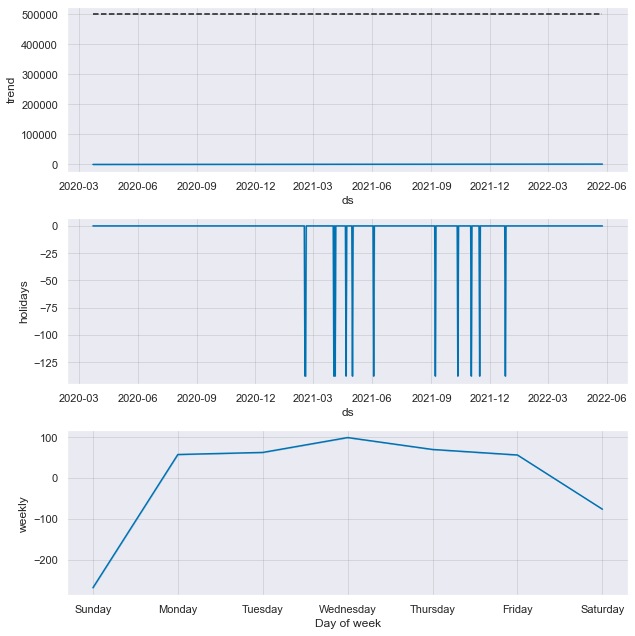

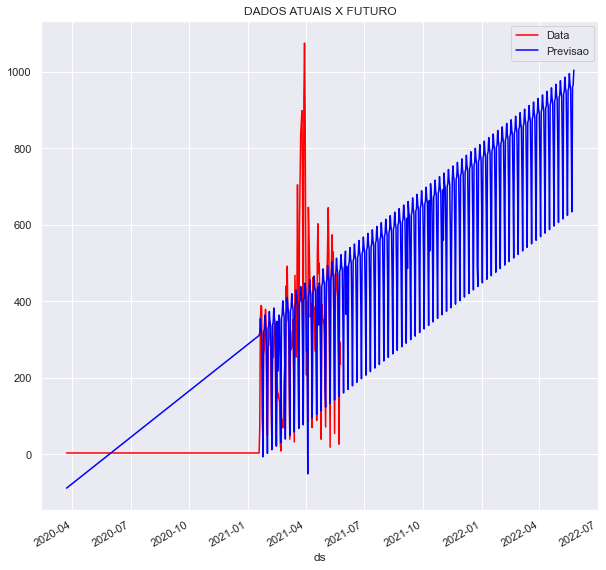

In [43]:
# Criando um Dataframe que contém as datas dos feriados:

# Fazendo a Previsao:

model    = Prophet(holidays = holidays)

# Treinando:

forecast = model.fit(df1).predict(future)  
model.plot_components(forecast);

# Plotting com a nova previsao:

ax = (df1.plot(x= 'ds', y = 'y',   legend = True, label = 'Data', figsize= (10,30), color = 'red')) 
forecast.plot(x= 'ds',  y ='yhat', legend = True, label = 'Previsao', figsize=(10,10),title='DADOS ATUAIS X FUTURO', color ='blue',ax=ax)

# 12.º Recalculando as Medidas do Cross_Validation

In [44]:
# Recalculando a Função Croos-Validation

df_cross = cross_validation(model, initial='365 days', period='10 days', horizon = '30 days')

df_cross.head()
df_perform = performance_metrics(df_cross)
df_perform.head()



INFO:prophet:Making 4 forecasts with cutoffs between 2021-03-26 00:00:00 and 2021-04-25 00:00:00


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,57241.819668,239.252627,181.353844,0.468125,0.484604,0.463641,0.750000
1,4 days,79279.412496,281.566000,187.980603,0.415613,0.405419,0.424800,0.833333
2,5 days,97899.167700,312.888427,229.101461,0.445687,0.461588,0.449031,0.750000
3,6 days,71421.234247,267.247515,183.849404,0.425160,0.313057,0.397660,0.833333
4,7 days,28201.781730,167.933861,125.073022,0.488333,0.276736,0.378287,0.916667


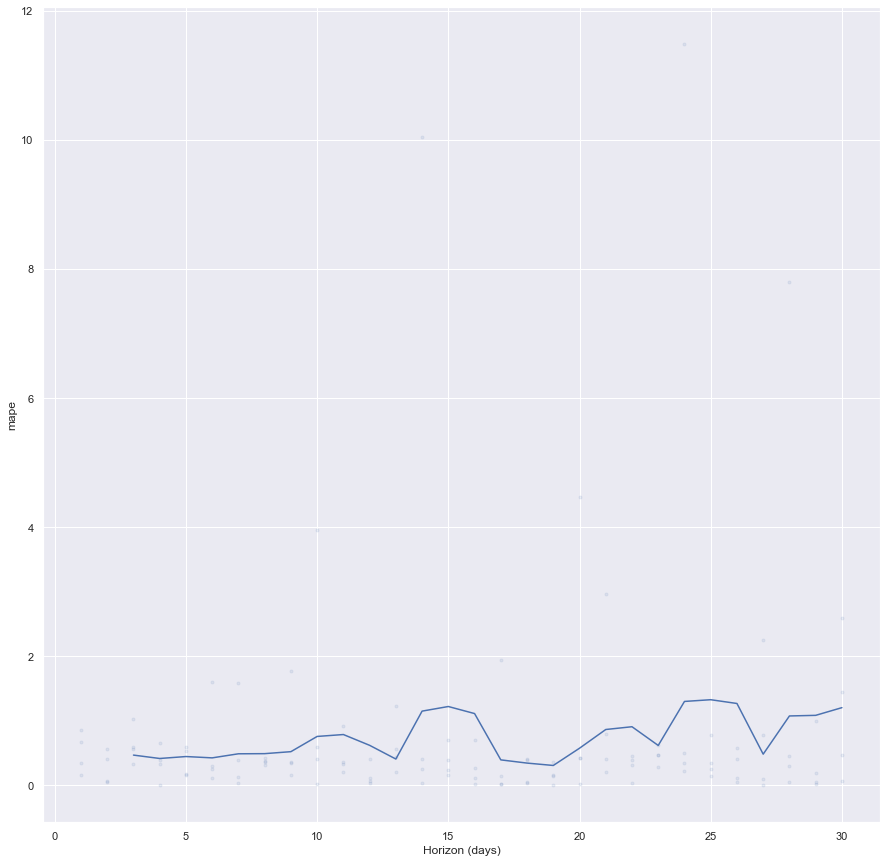

In [45]:
# Plotting a Performance: MAPE (Mean absolute percentage error)
# 
fig = plot_cross_validation_metric(df_cross, metric='mape', figsize = (15,15))

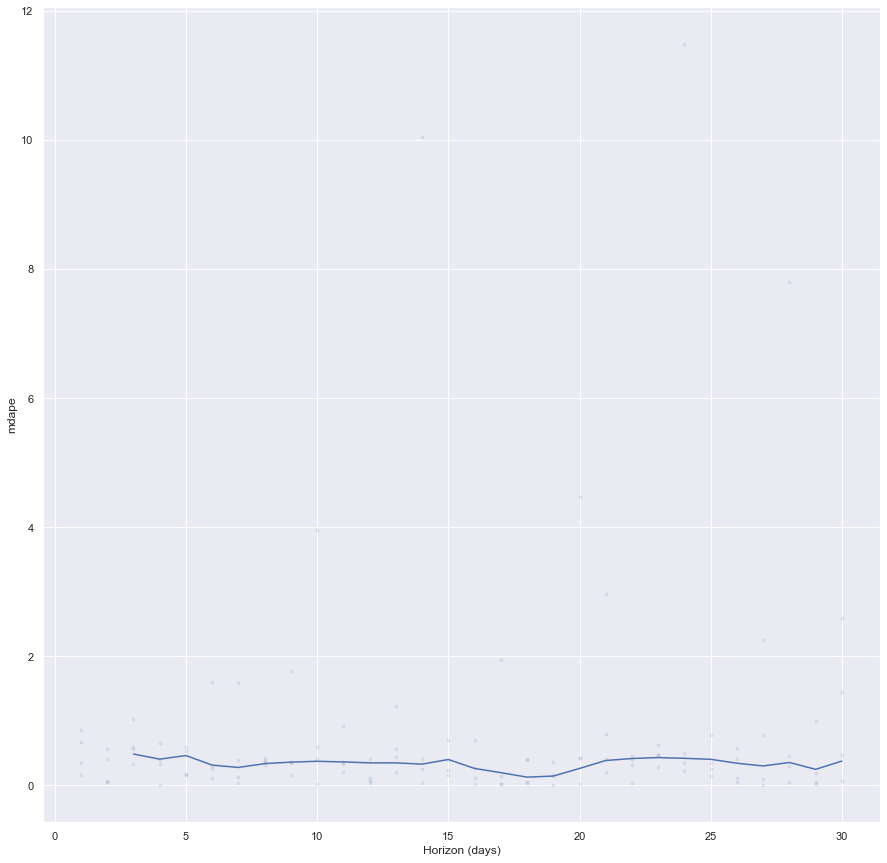

In [46]:
# Plotting Median Absolute Percentage Error: MDAPE
figura = plot_cross_validation_metric(df_cross,metric = 'mdape', figsize = (15,15))

# Aqui finalizamos a análise da vacina 1. Dose
## Conclusão: 
a melhor performance obtida pelo algoritmo Prophet 
foi na primeira execução Propet, pelos valores do MAPE.

A segunda vez que foi rodado o algoritmo alterando os parámetros, na
computação com os valores obtido do MAPE foram os mais altos.
E no final, a configuração do calendário de feriados no Brasil, foi melhor
do que a segunda vez, mas a primeira execução obtive os melhores valores.


# 13.º Passo:
Aqui estarei fazendo as Previsões da Segunda Dose da Vacina:

In [ ]:
df2 = df
df2.shape

In [ ]:
df2 = df.groupby('vacina_dataAplicacao').agg({'2a_dose':'sum'}).reset_index()

df2['vacina_dataAplicacao'].value_counts()

In [ ]:
# Renomeando as colunas para preparar para rodar o Modelo Prophet:

df2.columns = ['ds', 'y']

In [ ]:
df2

In [ ]:
# Plotting Data Atual

df2.plot(x ='ds', y ='y', figsize = (10,8), title = 'Datas Vacinação da 2. Dose' , color = 'red')

In [ ]:
# Fazendo Saturações Previsões de Crescimento com Prophet sem nenhum parâmetros:

model = Prophet()

model.fit(df2)

future   = model.make_future_dataframe(periods = 365)

forecast = model.predict(future)

fig1 = model.plot(forecast)


In [ ]:
# Definindo os campos de y_true e y_pred para calcular erro,
# chamando a Função Mean_Absolute_Percentage_ERROR
# Após alterando parâmetros no Prophet:

y_true = df2['y']
y_pred = forecast['yhat'].loc[0:128]

mape = mean_absolute_percentage_error(y_true, y_pred)

print("MAPE", round(mape,4))


In [ ]:
# Definindo a sazonalidade diaria, semanal e mensal terá mais controle sobre a sazonalidade. 

model = Prophet(daily_seasonality      = False,
               weekly_seasonality      = False,
               yearly_seasonality      = False,
               ).add_seasonality(name= 'mounthly',
                                 period = 30,
                                 fourier_order = 12
                ).add_seasonality(name = 'dayly',
                                 period = 1,
                                 fourier_order = 15
                                 ).add_seasonality(name = 'weekly',
                                 period = 7,
                                 fourier_order = 20,
                ).add_seasonality(name= 'yearly',
                                 period = 365.25,
                                 fourier_order = 20
                ).add_seasonality(name= 'quartely',
                                 period = 365.25/4,
                                 fourier_order = 5,
                                 prior_scale = 15)
                

In [ ]:
# Recalculando a Função Croos-Validation

df_cross = cross_validation(model, initial='365 days', period='10 days', horizon = '30 days')

df_cross.head()
df_perform = performance_metrics(df_cross)
df_perform.head()


In [ ]:
# Plotting Median Absolute Percentage Error: MDAPE
figura = plot_cross_validation_metric(df_cross,metric = 'mdape', figsize = (15,15))

In [ ]:
# Plotting a Performance: MAPE (Mean absolute percentage error)
# 
fig = plot_cross_validation_metric(df_cross, metric='mape', figsize = (15,15))

# Tratando Parâmetros: ajustes dos parâmetros do PROPHETS para '2a_dose':

In [ ]:
# Aqui faremos os ajustes para melhorar a nossa previsão:

# Prophet usa um modelo linear para sua previsão, e podemos usar um modelo de
# 1) A tendência de crescimento logística, 'growth = logistic'

# 2) Dois parâmetros são importantes no modelo:
# o parâmetro FLOOR = 0 ==> mínimo de saturação 
# o parâmetro CAP   =   ==> especifica o valor máximo, CAP = populacao brasileira

# 3) Parâmetro Trend, podemos ajustar a flexibilizar a tendência:

# Se as mudanças de tendência estão sendo super ajustadas (flexibilidade demais) ou insuficientes (flexibilidade insuficiente), você pode ajustar a força da dispersão antes de usar o argumento de entrada changepoint_prior_scale. 
# Por padrão, este parâmetro é definido como 0,05. 
# Aumentá-lo tornará a tendência mais flexível


# OBS: FLOOR e CAP devem ser especificados para CADA colunas do DataFrame, com
# valores mínimo e Máximo

df2['cap']  = 7000    # media vacinados por dia
df2['floor'] = 1      # valor do piso

model = Prophet(growth = 'logistic', changepoint_prior_scale = 0.5)  # define crescimento logistico
 
# Calculando fit:
model.fit(df2)

# Fazendo a previsão:

future          = model.make_future_dataframe(periods = 365)
future['cap']   = 211755692   # total da população brasileira
future['floor'] = 1
forecast = model.predict(future)

fig3 = model.plot(forecast)

In [ ]:
# Explicando as métricas:

# yhat: o valor previsto de nossa métrica (em Estatísticas, 
#       yhat é uma notação tradicionalmente usada para representar os valores previstos de um valor y)

# yhat_lower: o limite inferior de nossas previsões
# yhat_upper: o limite superior de nossas previsões


forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
# Fazendo o Plotagem:

fig = model.plot(forecast)

fig = model.plot_components(forecast)

In [ ]:
# Recalculando a Função Croos-Validation

df_cross = cross_validation(model, initial='365 days', period='10 days', horizon = '30 days')

df_cross.head()
df_perform = performance_metrics(df_cross)
df_perform.head()


In [ ]:
# Plotting Median Absolute Percentage Error: MDAPE
figura = plot_cross_validation_metric(df_cross,metric = 'mdape', figsize = (15,15))

In [ ]:
# Plotting a Performance: MAPE (Mean absolute percentage error)
# 
fig = plot_cross_validation_metric(df_cross, metric='mape', figsize = (15,15))

In [ ]:
# Definindo os campos de y_true e y_pred para calcular erro,
# chamando a Função Mean_Absolute_Percentage_ERROR
# Após alteração parâmetros no Prophet:

y_true = df2['y']
y_pred = forecast['yhat'].loc[0:128]

mape = mean_absolute_percentage_error(y_true, y_pred)

print("MAPE", round(mape,4))
